<a href="https://colab.research.google.com/github/shuuuuyu/114-1-Programing-Language/blob/main/%E4%BD%9C%E6%A5%AD%E4%B8%89%EF%BC%9A%E5%BE%85%E8%BE%A6%E6%B8%85%E5%96%AE%E8%88%87%E7%95%AA%E8%8C%84%E9%90%98%E7%B4%80%E9%8C%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍅 Pomodoro To-Do 專案說明

這是一個結合 **任務管理**、**番茄鐘計時**、**AI 任務規劃** 與 **統計視覺化** 的效率工具。
所有資料會同步儲存在 **Google Sheet**，方便管理與備份。



## 📊 Google Sheet 架構
https://docs.google.com/spreadsheets/d/1KfJ0Y6b-ilMsw1EdqFLOah7vP7uote5h5MKKs2nhL-s/edit?gid=436051288#gid=436051288

| 分頁名稱            | 內容    | 說明                        |
| --------------- | ----- | ------------------------- |
| `tasks`         | 任務清單  | 記錄任務名稱、截止時間、優先順序、狀態與番茄鐘數量 |
| `pomodoro_logs` | 番茄鐘記錄 | 儲存每次專注的開始時間、結束時間、評分與備註    |

> 💡 `task_id` 為兩者的關聯鍵
> 例如：一個任務可對應多筆番茄鐘紀錄（1 對多關係）



## 🧭 建議使用順序

1.  **📝 任務管理**：新增或刪除任務，設定截止時間與優先順序。狀態自動從 `pending → in_progress → completed`（需手動確認完成）。

2. **🤖 AI 助理（選用）**：點擊「生成排程」讓 AI 根據任務優先度與截止時間，自動規劃早、中、晚工作時段。

3. **🍅 番茄鐘計時**：輸入任務 ID 與時間（可自訂 25 或 30 分鐘），開始專注。完成後評分與備註，系統自動：

    * 新增一筆 log
    * 任務番茄鐘數 +1
    * 狀態更新為 `in_progress`

4.  **📊 報表分析**：點擊「生成統計」查看：

    * 任務完成率
    * 每週番茄鐘分布
    * 平均效率。可匯出 CSV

---

## 🔁 任務與紀錄關係圖

```
tasks
└── 任務 A（task_id: a1b2c3d4）
    ├─ log1：10:00-10:25 ✅ 4星
    ├─ log2：11:00-11:25 ✅ 5星
    └─ log3：14:00-14:25 ✅ 3星
```



## ⚙️ 小提醒

* 開始番茄鐘後會自動將任務設為「進行中」
* 結束後需手動確認任務是否真正完成
* 可中途放棄（不增加番茄鐘次數）
* 可直接標記任務完成，不必使用番茄鐘



## ✅ 最簡流程

```
1. 新增任務
2. 開始番茄鐘（可自訂時間）
3. 完成後評分 → 自動更新紀錄
4. 任務完成時手動標記「completed」
5. 報表分析 → 匯出 CSV/JSON
```


### 🪄 特色

* I/O to Google Sheet
* list / dict 資料結構
* 匯出 / 匯入 CSV、JSON
* 視覺化統計（Plotly / Seaborn）
* 可刪除任務、依日期與狀態查詢
* 可自訂番茄鐘時間



## 畫面截圖

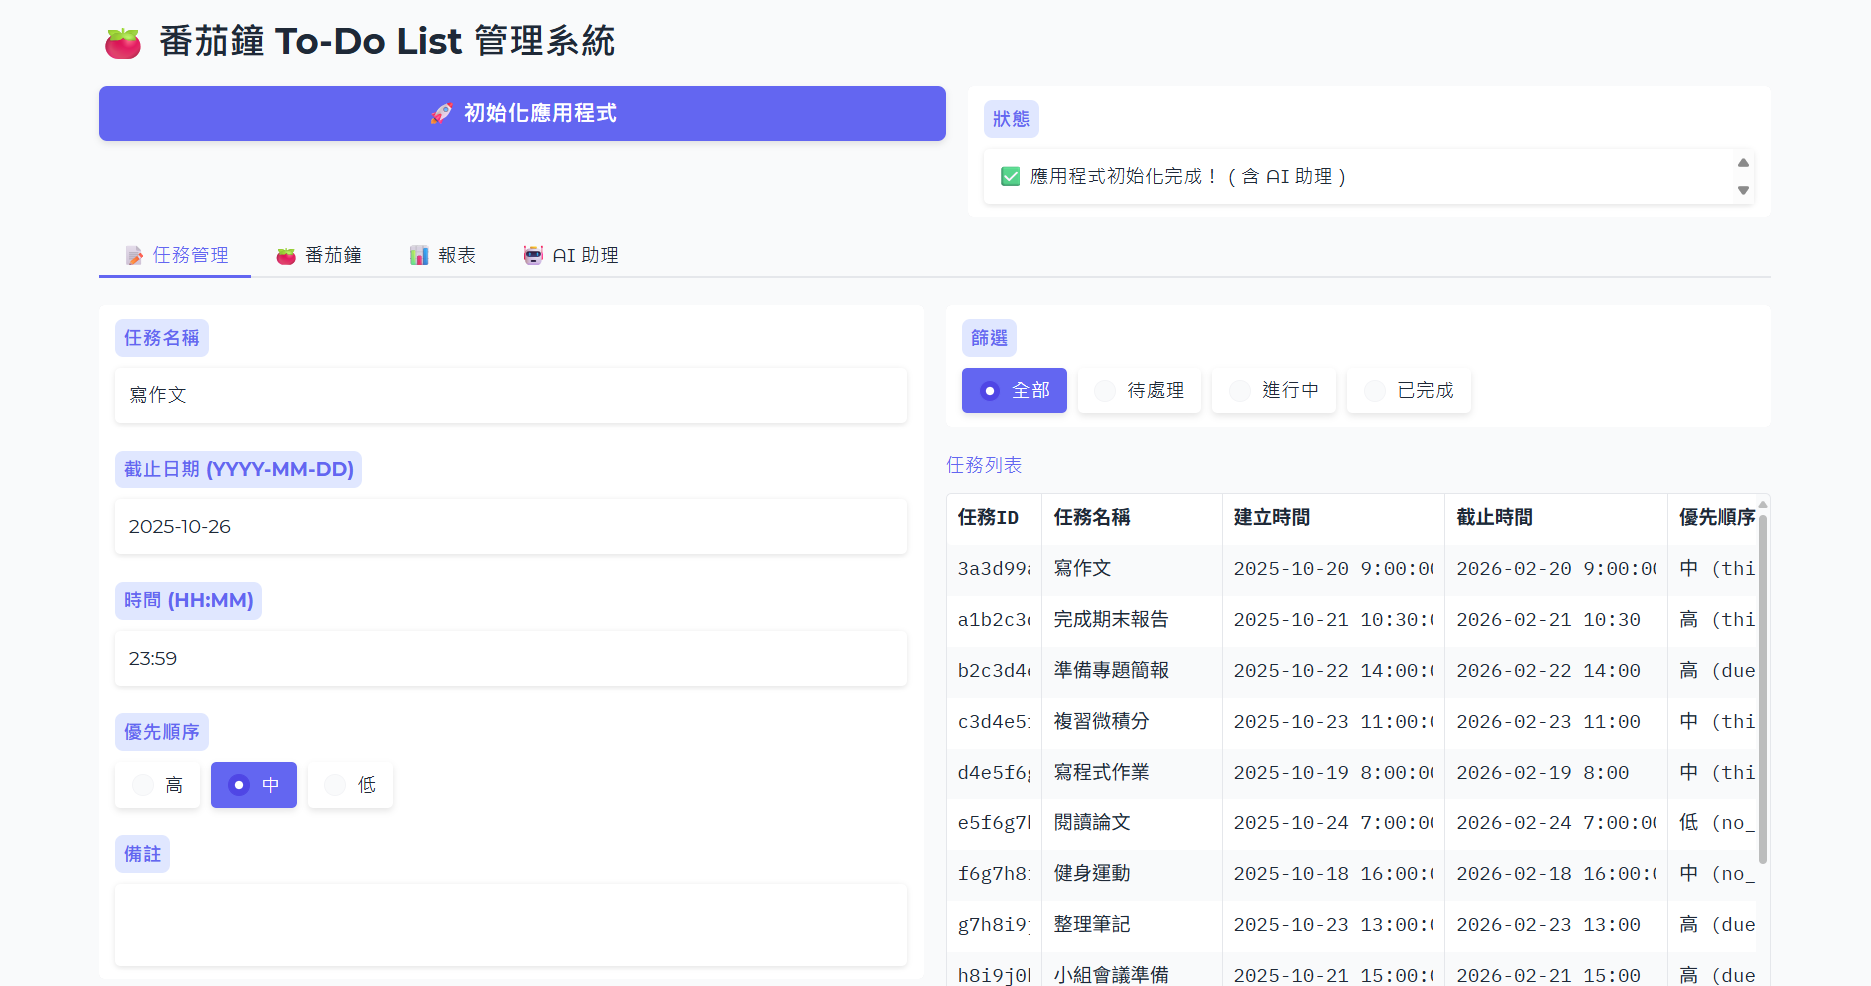

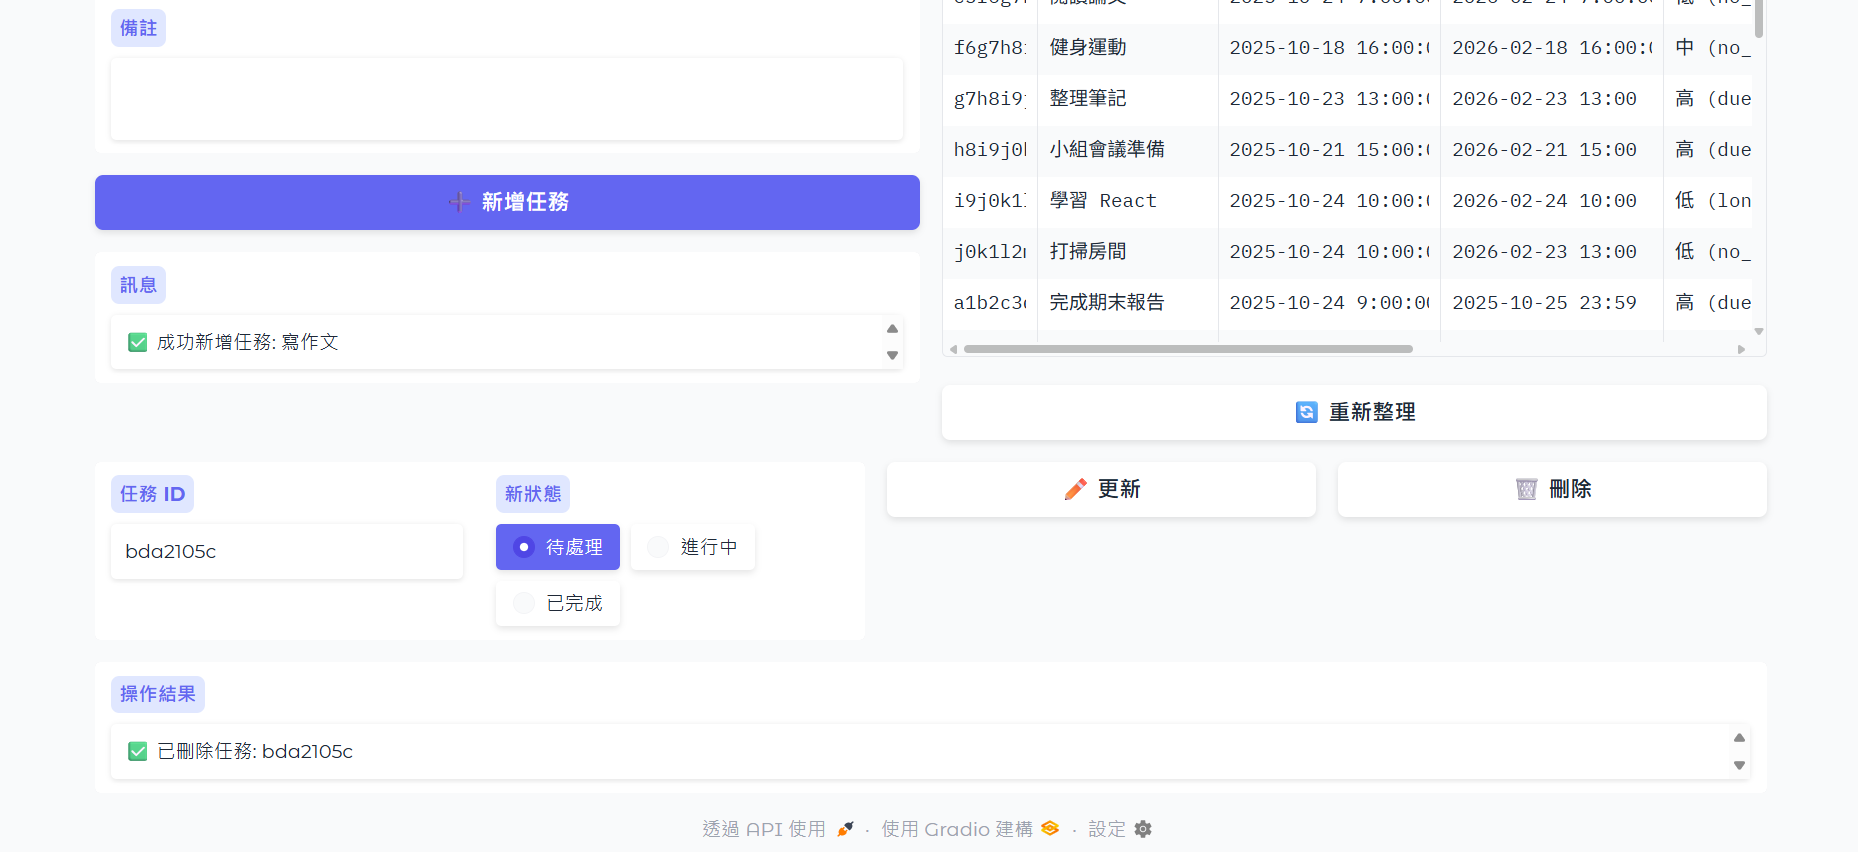

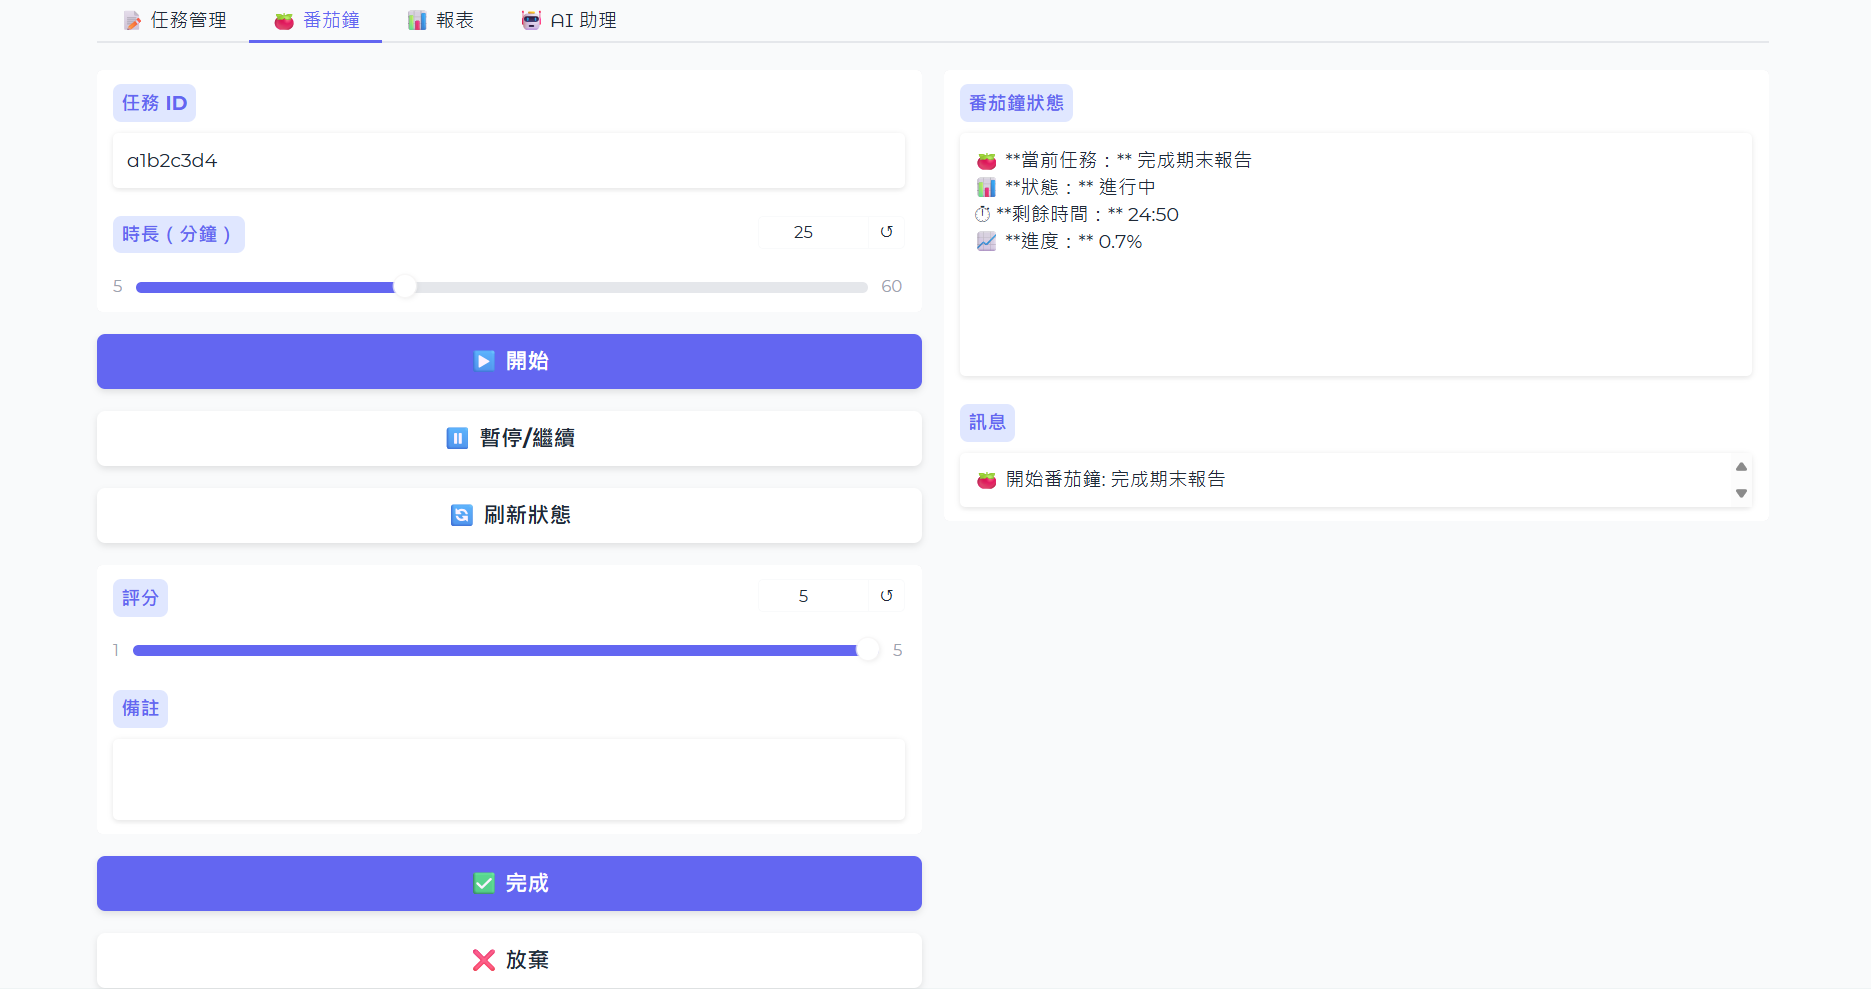

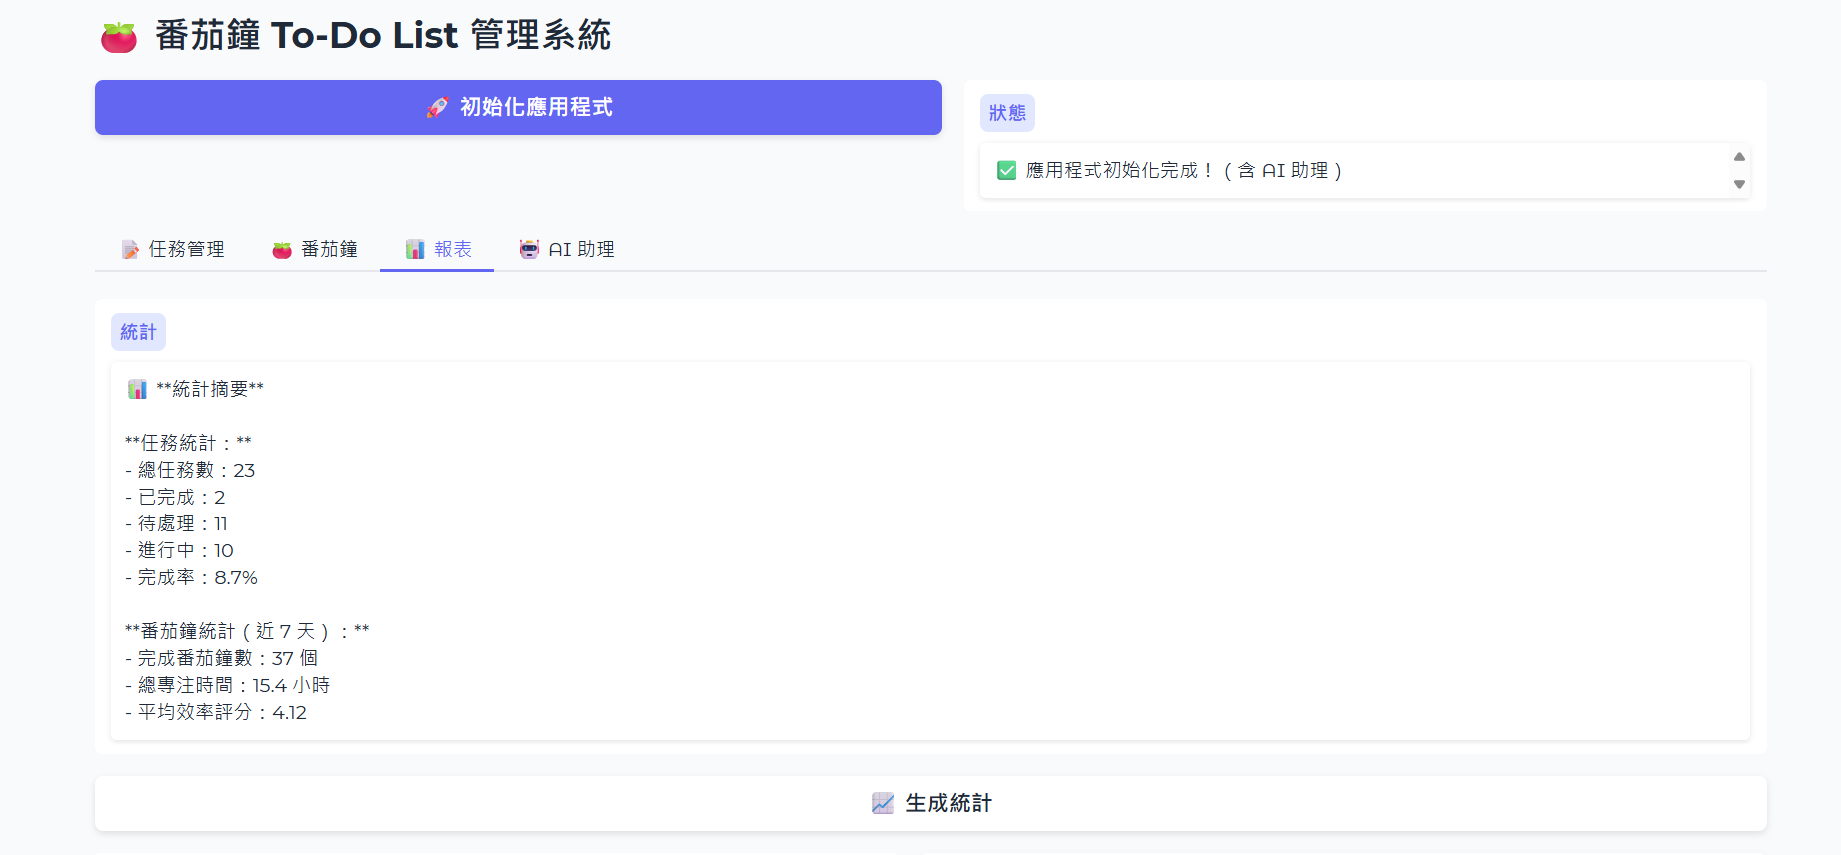

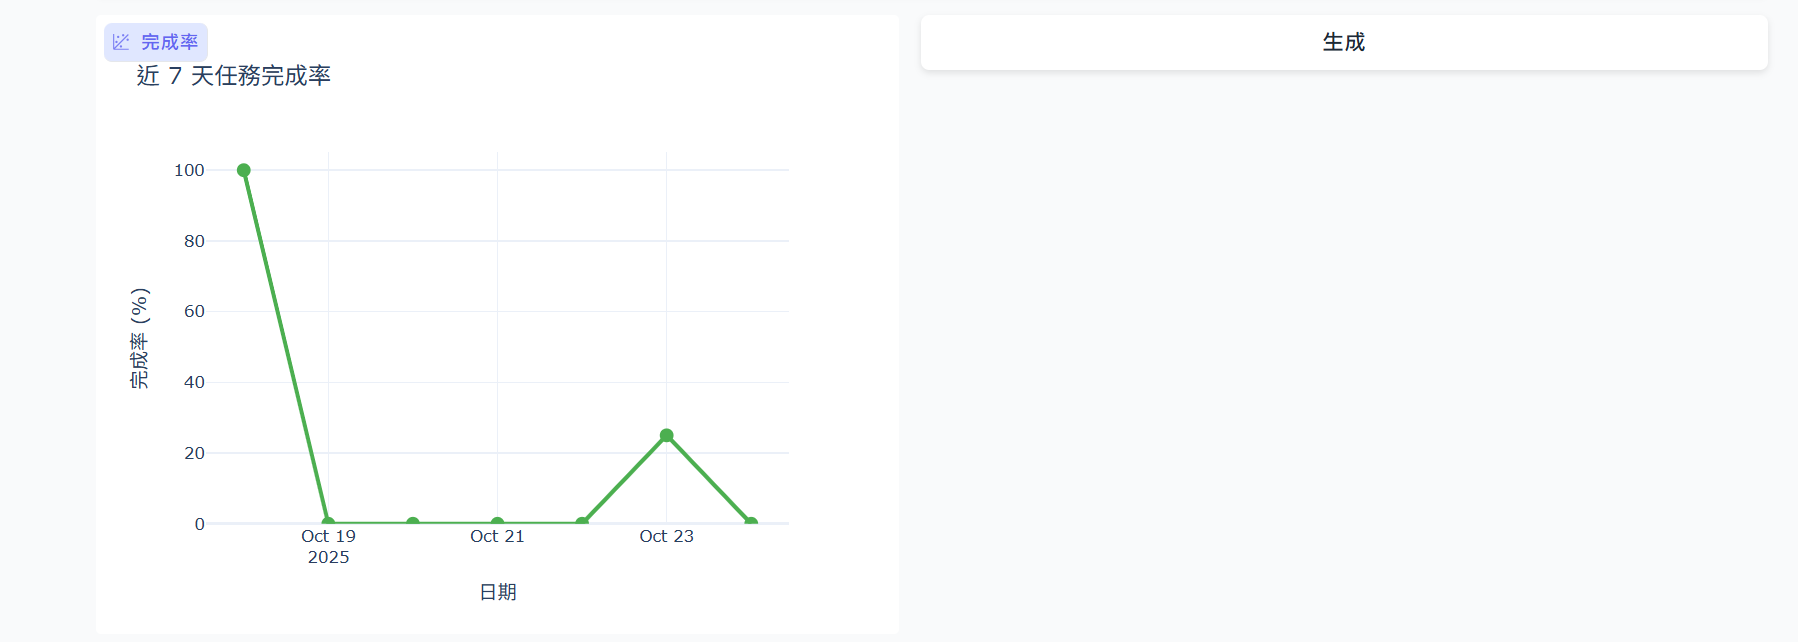


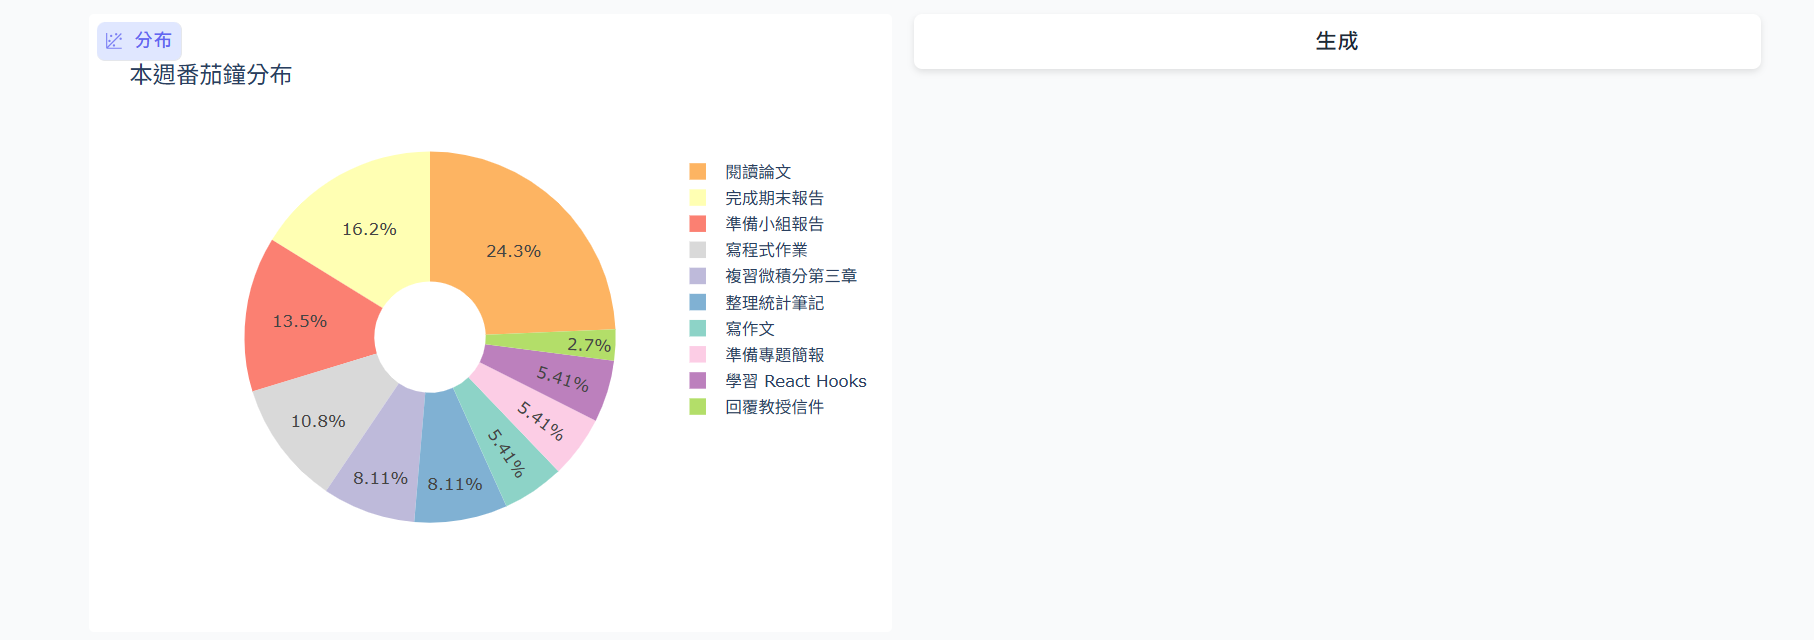

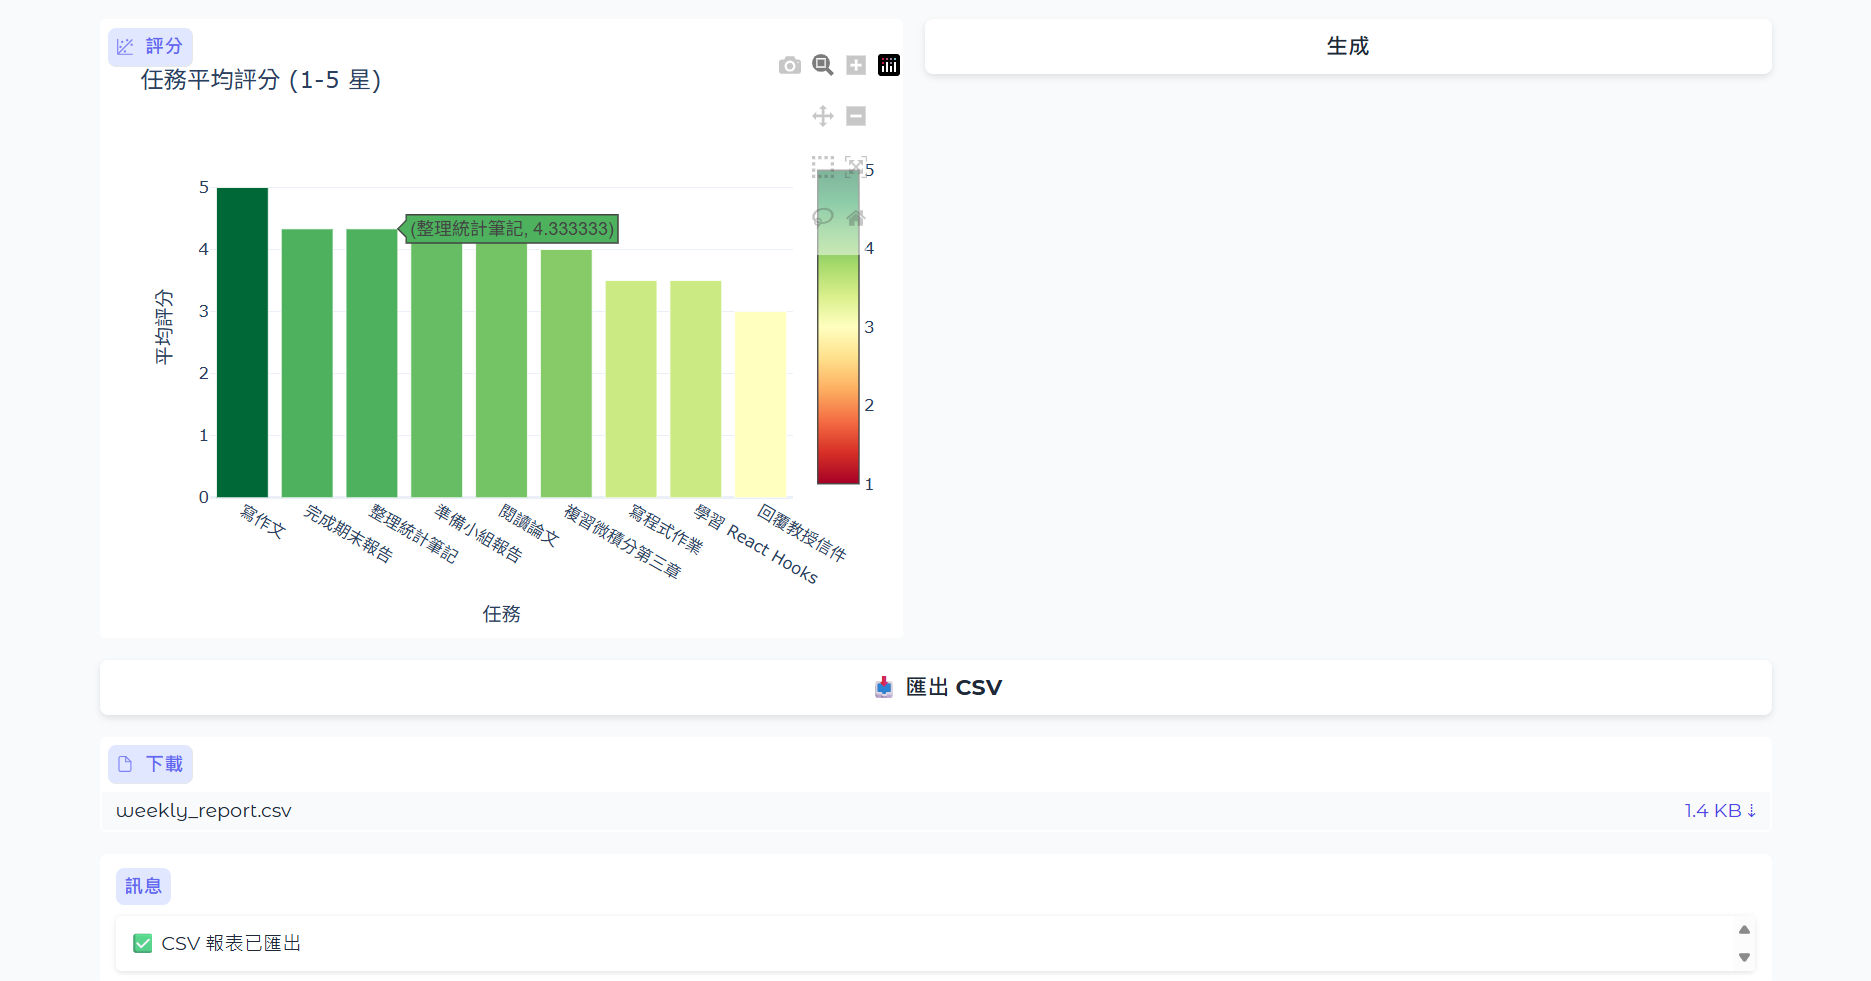

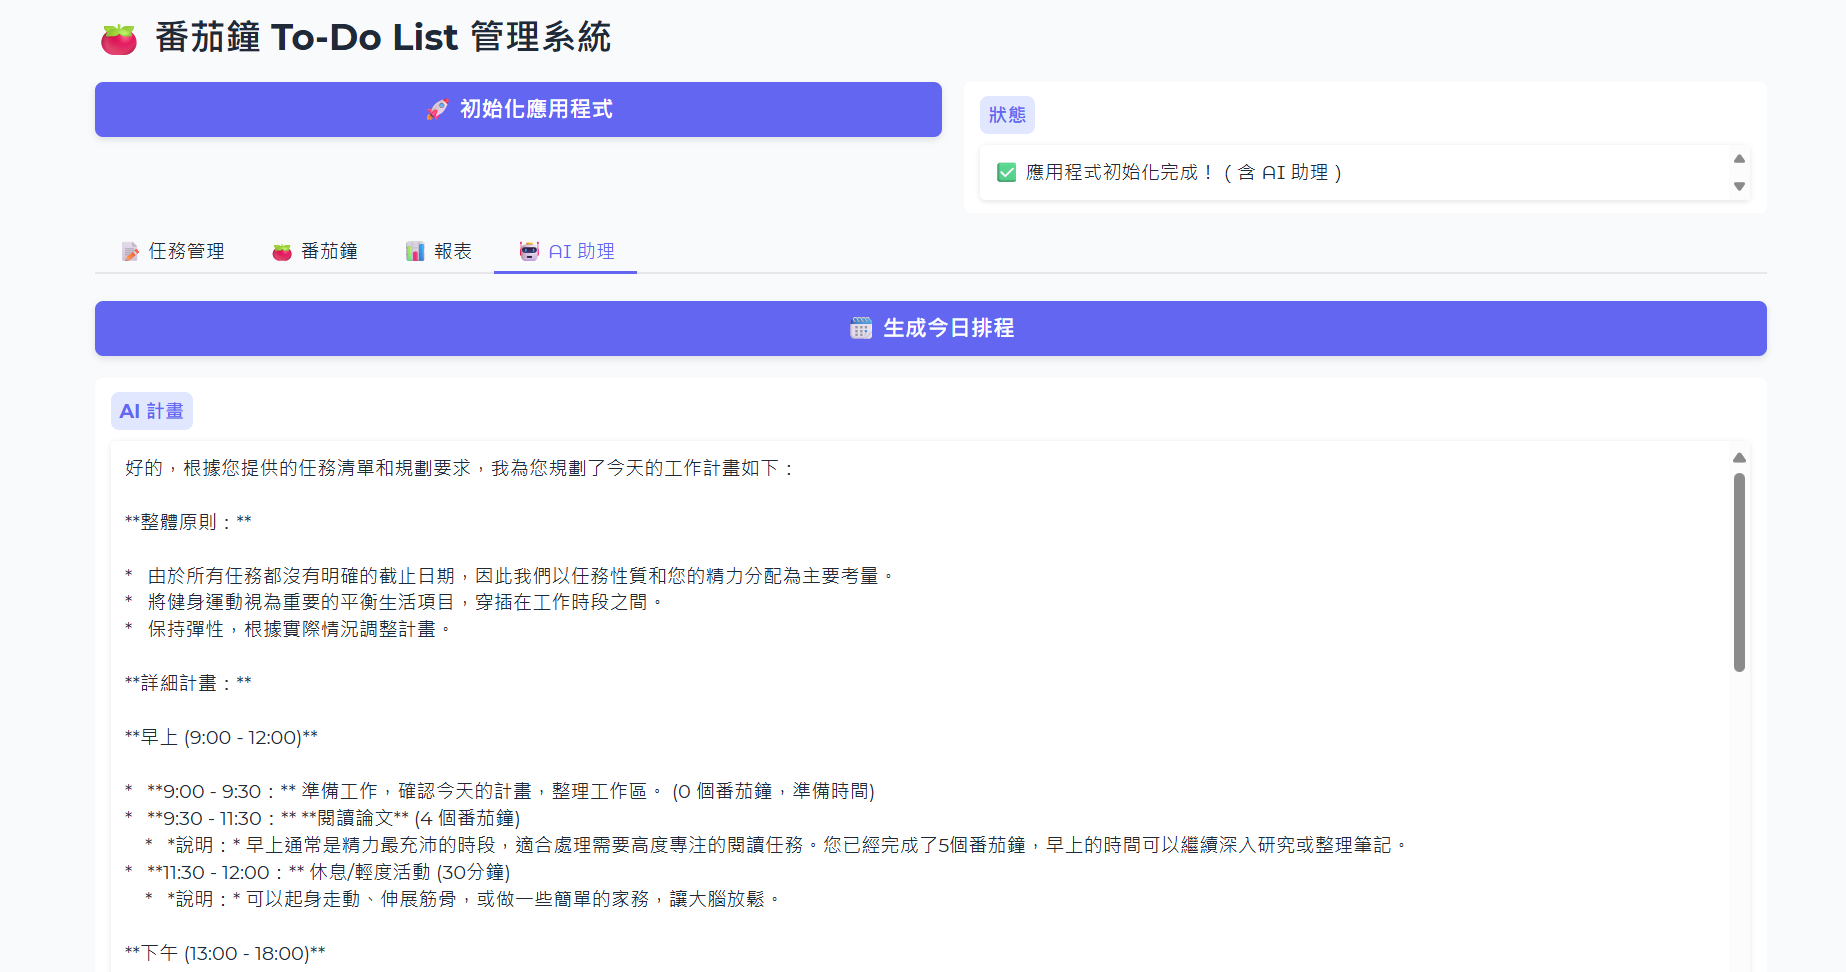

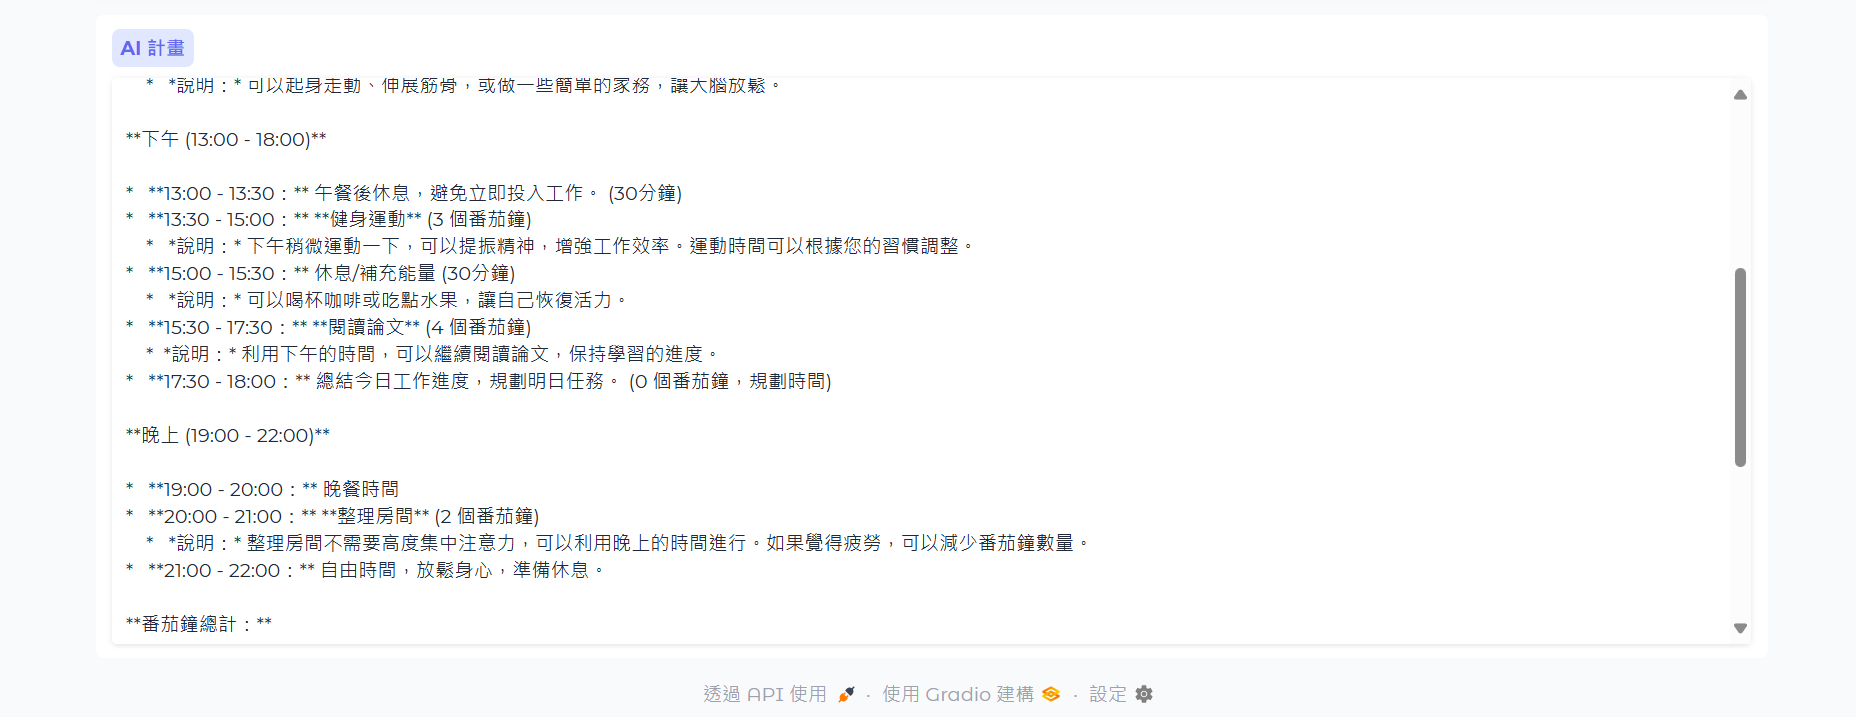

## 程式部分

In [9]:
# 完整的 Colab 設定
!pip install gradio gspread google-auth plotly pandas requests -q

from google.colab import auth
from google.auth import default
import gspread

# 授權
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

print("✅ 授權完成！現在可以上傳並執行 pomodoro_app_all_in_one.py")

✅ 授權完成！現在可以上傳並執行 pomodoro_app_all_in_one.py


In [5]:
from google.colab import userdata

try:
    api_key = userdata.get('gemini')
    print("✅ Gemini API 金鑰已設定")
except:
    print("⚠️ 請在左側 Secrets 中設定 'gemini' API 金鑰")

✅ Gemini API 金鑰已設定


In [8]:
# 匯入必要套件
import gradio as gr
import gspread
from datetime import datetime, timedelta
import uuid
import json
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import csv
import requests
import time
from google.colab import userdata
from google.colab import auth
from google.auth import default

# ==================== TaskManager ====================
class TaskManager:
    """任務管理器 - 負責 Google Sheet 的 CRUD 操作"""

    def __init__(self, sheet_url):
        self.sheet_url = sheet_url
        self.sheet = None
        self.tasks_worksheet = None
        self.pomodoro_worksheet = None
        self._connect_sheet()

    def _connect_sheet(self):
        """連接到 Google Sheet"""
        try:
            auth.authenticate_user()
            creds, _ = default()
            gc = gspread.authorize(creds)

            self.sheet = gc.open_by_url(self.sheet_url)

            try:
                self.tasks_worksheet = self.sheet.worksheet('tasks')
            except:
                self.tasks_worksheet = self.sheet.add_worksheet(title='tasks', rows=1000, cols=10)
                headers = ['task_id', 'task_name', 'created_at', 'due_date',
                          'priority', 'status', 'pomodoro_count', 'notes']
                self.tasks_worksheet.append_row(headers)

            try:
                self.pomodoro_worksheet = self.sheet.worksheet('pomodoro_logs')
            except:
                self.pomodoro_worksheet = self.sheet.add_worksheet(title='pomodoro_logs', rows=1000, cols=10)
                headers = ['log_id', 'task_id', 'start_time', 'end_time',
                          'completed', 'rating', 'notes']
                self.pomodoro_worksheet.append_row(headers)

            print("✅ 成功連接到 Google Sheet")
        except Exception as e:
            print(f"❌ 連接 Google Sheet 失敗: {e}")

    def add_task(self, task_name, due_date=None, priority='中', notes=''):
        """新增任務"""
        task_id = str(uuid.uuid4())[:8]
        created_at = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        priority_tag = self._calculate_priority_tag(due_date)

        row = [task_id, task_name, created_at, due_date if due_date else '',
               f"{priority} ({priority_tag})", 'pending', 0, notes]

        self.tasks_worksheet.append_row(row)
        print(f"✅ 新增任務成功: {task_name} (ID: {task_id})")
        return task_id

    def _calculate_priority_tag(self, due_date):
        """計算優先順序標籤"""
        if not due_date:
            return 'no_deadline'
        try:
            due = datetime.strptime(due_date, '%Y-%m-%d %H:%M')
            now = datetime.now()
            delta = due - now
            if delta.total_seconds() < 0:
                return 'overdue'
            elif delta.days < 1:
                return 'due_soon'
            elif delta.days > 7:
                return 'long_term'
            else:
                return 'this_week'
        except:
            return 'invalid_date'

    def get_all_tasks(self):
        """獲取所有任務"""
        try:
            return self.tasks_worksheet.get_all_records()
        except:
            return []

    def get_tasks_by_status(self, status):
        """根據狀態查詢任務"""
        all_tasks = self.get_all_tasks()
        return [task for task in all_tasks if task['status'] == status]

    def update_task_status(self, task_id, new_status):
        """更新任務狀態"""
        try:
            cell = self.tasks_worksheet.find(task_id)
            self.tasks_worksheet.update_cell(cell.row, 6, new_status)
            print(f"✅ 更新任務狀態成功: {task_id} -> {new_status}")
            return True
        except Exception as e:
            print(f"❌ 更新任務狀態失敗: {e}")
            return False

    def increment_pomodoro_count(self, task_id):
        """增加番茄鐘計數"""
        try:
            cell = self.tasks_worksheet.find(task_id)
            row = cell.row
            current_count = self.tasks_worksheet.cell(row, 7).value
            new_count = int(current_count) + 1 if current_count else 1
            self.tasks_worksheet.update_cell(row, 7, new_count)
            print(f"✅ 番茄鐘計數 +1: {task_id}")
            return True
        except Exception as e:
            print(f"❌ 更新番茄鐘計數失敗: {e}")
            return False

    def delete_task(self, task_id):
        """刪除任務"""
        try:
            cell = self.tasks_worksheet.find(task_id)
            self.tasks_worksheet.delete_rows(cell.row)
            print(f"✅ 刪除任務成功: {task_id}")
            return True
        except Exception as e:
            print(f"❌ 刪除任務失敗: {e}")
            return False

    def add_pomodoro_log(self, task_id, start_time, end_time, completed, rating=0, notes=''):
        """記錄番茄鐘"""
        log_id = str(uuid.uuid4())[:8]
        row = [log_id, task_id,
               start_time.strftime('%Y-%m-%d %H:%M:%S'),
               end_time.strftime('%Y-%m-%d %H:%M:%S') if end_time else '',
               completed, rating, notes]

        self.pomodoro_worksheet.append_row(row)
        if completed:
            self.increment_pomodoro_count(task_id)
        print(f"✅ 記錄番茄鐘成功")

    def get_pomodoro_logs(self, days=7):
        """獲取番茄鐘記錄"""
        try:
            records = self.pomodoro_worksheet.get_all_records()
            cutoff_date = datetime.now() - timedelta(days=days)
            filtered = []
            for log in records:
                try:
                    log_date = datetime.strptime(log['start_time'], '%Y-%m-%d %H:%M:%S')
                    if log_date >= cutoff_date:
                        filtered.append(log)
                except:
                    continue
            return filtered
        except:
            return []

    def get_today_tasks(self):
        """獲取今日任務"""
        all_tasks = self.get_all_tasks()
        today = datetime.now().date()
        today_tasks = []

        for task in all_tasks:
            if task['status'] in ['pending', 'in_progress']:
                if task['due_date']:
                    try:
                        due = datetime.strptime(task['due_date'], '%Y-%m-%d %H:%M').date()
                        if due <= today:
                            today_tasks.append(task)
                    except:
                        continue
                else:
                    today_tasks.append(task)

        return today_tasks

# ==================== PomodoroTimer ====================
class PomodoroTimer:
    """番茄鐘計時器"""

    def __init__(self, duration_minutes=25):
        self.duration_minutes = duration_minutes
        self.duration_seconds = duration_minutes * 60
        self.remaining_seconds = self.duration_seconds
        self.is_running = False
        self.is_paused = False
        self.start_time = None
        self.pause_time = None

    def start(self):
        """開始計時"""
        if not self.is_running:
            self.is_running = True
            self.is_paused = False
            self.start_time = datetime.now()
            print(f"⏰ 番茄鐘開始: {self.duration_minutes} 分鐘")
            return True
        return False

    def pause(self):
        """暫停計時"""
        if self.is_running and not self.is_paused:
            self.is_paused = True
            self.pause_time = datetime.now()
            print("⏸ 番茄鐘已暫停")
            return True
        return False

    def resume(self):
        """繼續計時"""
        if self.is_running and self.is_paused:
            self.is_paused = False
            pause_duration = datetime.now() - self.pause_time
            self.start_time += pause_duration
            print("▶️ 番茄鐘繼續")
            return True
        return False

    def stop(self, completed=True):
        """停止計時"""
        if self.is_running:
            end_time = datetime.now()
            result = {
                'start_time': self.start_time,
                'end_time': end_time,
                'completed': completed,
                'duration_minutes': (end_time - self.start_time).seconds / 60
            }

            self.is_running = False
            self.is_paused = False
            self.remaining_seconds = self.duration_seconds

            print("✅ 番茄鐘完成！" if completed else "❌ 番茄鐘已放棄")
            return result
        return None

    def get_remaining_time(self):
        """獲取剩餘時間"""
        if not self.is_running:
            return self.duration_seconds

        if self.is_paused:
            elapsed = (self.pause_time - self.start_time).seconds
        else:
            elapsed = (datetime.now() - self.start_time).seconds

        return max(0, self.duration_seconds - elapsed)

    def get_remaining_time_str(self):
        """獲取剩餘時間字串"""
        remaining = self.get_remaining_time()
        minutes = remaining // 60
        seconds = remaining % 60
        return f"{minutes:02d}:{seconds:02d}"

    def get_status(self):
        """獲取狀態"""
        if not self.is_running:
            return "未開始"
        elif self.is_paused:
            return "已暫停"
        elif self.get_remaining_time() == 0:
            return "時間到！"
        else:
            return "進行中"

    def get_progress_percentage(self):
        """獲取進度"""
        if not self.is_running:
            return 0
        elapsed = self.duration_seconds - self.get_remaining_time()
        return min(100, (elapsed / self.duration_seconds) * 100)

    def reset(self, duration_minutes=None):
        """重置"""
        self.is_running = False
        self.is_paused = False
        self.start_time = None
        self.pause_time = None

        if duration_minutes:
            self.duration_minutes = duration_minutes
            self.duration_seconds = duration_minutes * 60

        self.remaining_seconds = self.duration_seconds

class PomodoroSession:
    """番茄鐘會話"""

    def __init__(self, task_manager):
        self.task_manager = task_manager
        self.timer = PomodoroTimer()
        self.current_task_id = None
        self.current_task_name = None

    def start_session(self, task_id, task_name, duration_minutes=25):
        """開始會話"""
        self.current_task_id = task_id
        self.current_task_name = task_name
        self.timer.reset(duration_minutes)
        self.timer.start()
        self.task_manager.update_task_status(task_id, 'in_progress')
        print(f"🍅 開始番茄鐘: {task_name}")

    def complete_session(self, rating=0, notes=''):
        """完成會話"""
        if self.current_task_id:
            result = self.timer.stop(completed=True)
            self.task_manager.add_pomodoro_log(
                self.current_task_id, result['start_time'],
                result['end_time'], True, rating, notes
            )
            task_name = self.current_task_name
            self.current_task_id = None
            self.current_task_name = None
            return f"✅ 完成番茄鐘: {task_name}"
        return "⚠️ 沒有進行中的番茄鐘"

    def abandon_session(self, notes=''):
        """放棄會話"""
        if self.current_task_id:
            result = self.timer.stop(completed=False)
            self.task_manager.add_pomodoro_log(
                self.current_task_id, result['start_time'],
                result['end_time'], False, 0, notes
            )
            self.task_manager.update_task_status(self.current_task_id, 'pending')
            task_name = self.current_task_name
            self.current_task_id = None
            self.current_task_name = None
            return f"❌ 已放棄番茄鐘: {task_name}"
        return "⚠️ 沒有進行中的番茄鐘"

    def get_session_info(self):
        """獲取會話資訊"""
        return {
            'task_id': self.current_task_id,
            'task_name': self.current_task_name,
            'status': self.timer.get_status(),
            'remaining': self.timer.get_remaining_time_str(),
            'progress': self.timer.get_progress_percentage()
        }

# ==================== ReportVisualizer ====================
class ReportVisualizer:
    """報表視覺化"""

    def __init__(self, task_manager):
        self.task_manager = task_manager

    def generate_weekly_completion_chart(self):
        """每週完成率圖表"""
        today = datetime.now()
        dates = [(today - timedelta(days=i)).date() for i in range(6, -1, -1)]
        all_tasks = self.task_manager.get_all_tasks()

        completion_data = []
        for date in dates:
            date_str = date.strftime('%Y-%m-%d')
            total = 0
            completed = 0

            for task in all_tasks:
                if task.get('created_at', '').startswith(date_str):
                    total += 1
                    if task['status'] == 'completed':
                        completed += 1

            rate = (completed / total * 100) if total > 0 else 0
            completion_data.append({'date': date_str, 'completion_rate': rate})

        df = pd.DataFrame(completion_data)
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=df['date'], y=df['completion_rate'],
            mode='lines+markers', name='完成率',
            line=dict(color='#4CAF50', width=3),
            marker=dict(size=10)
        ))
        fig.update_layout(
            title='近 7 天任務完成率',
            xaxis_title='日期', yaxis_title='完成率 (%)',
            yaxis=dict(range=[0, 105]), template='plotly_white'
        )
        return fig

    def generate_pomodoro_distribution_chart(self):
        """番茄鐘分布圖"""
        logs = self.task_manager.get_pomodoro_logs(days=7)

        if not logs:
            fig = go.Figure()
            fig.add_annotation(
                text="本週尚無番茄鐘記錄",
                xref="paper", yref="paper", x=0.5, y=0.5,
                showarrow=False, font=dict(size=20)
            )
            return fig

        task_counts = {}
        for log in logs:
            if log['completed']:
                task_id = log['task_id']
                task_counts[task_id] = task_counts.get(task_id, 0) + 1

        all_tasks = self.task_manager.get_all_tasks()
        task_names = {task['task_id']: task['task_name'] for task in all_tasks}

        labels = [task_names.get(tid, f'任務 {tid}') for tid in task_counts.keys()]
        values = list(task_counts.values())

        fig = go.Figure(data=[go.Pie(
            labels=labels, values=values, hole=0.3,
            marker=dict(colors=px.colors.qualitative.Set3)
        )])
        fig.update_layout(title='本週番茄鐘分布', template='plotly_white')
        return fig

    def generate_average_rating_chart(self):
        """平均評分圖表"""
        logs = self.task_manager.get_pomodoro_logs(days=7)

        if not logs:
            fig = go.Figure()
            fig.add_annotation(
                text="本週尚無評分記錄",
                xref="paper", yref="paper", x=0.5, y=0.5,
                showarrow=False, font=dict(size=20)
            )
            return fig

        task_ratings = {}
        for log in logs:
            if log['completed'] and log['rating'] > 0:
                task_id = log['task_id']
                if task_id not in task_ratings:
                    task_ratings[task_id] = []
                task_ratings[task_id].append(log['rating'])

        avg_ratings = {tid: sum(ratings) / len(ratings)
                      for tid, ratings in task_ratings.items()}

        all_tasks = self.task_manager.get_all_tasks()
        task_names = {task['task_id']: task['task_name'] for task in all_tasks}

        labels = [task_names.get(tid, f'任務 {tid}')
                 for tid in sorted(avg_ratings.keys(),
                                  key=lambda x: avg_ratings[x], reverse=True)]
        values = [avg_ratings[tid] for tid in sorted(avg_ratings.keys(),
                                                     key=lambda x: avg_ratings[x], reverse=True)]

        fig = go.Figure(data=[go.Bar(
            x=labels, y=values,
            marker=dict(color=values, colorscale='RdYlGn',
                       cmin=1, cmax=5, showscale=True)
        )])
        fig.update_layout(
            title='任務平均評分 (1-5 星)',
            xaxis_title='任務', yaxis_title='平均評分',
            yaxis=dict(range=[0, 5.5]), template='plotly_white'
        )
        return fig

    def generate_summary_stats(self):
        """統計摘要"""
        tasks = self.task_manager.get_all_tasks()
        logs = self.task_manager.get_pomodoro_logs(days=7)

        total_tasks = len(tasks)
        completed_tasks = len([t for t in tasks if t['status'] == 'completed'])
        pending_tasks = len([t for t in tasks if t['status'] == 'pending'])
        in_progress_tasks = len([t for t in tasks if t['status'] == 'in_progress'])

        total_pomodoros = len([l for l in logs if l['completed']])
        total_minutes = total_pomodoros * 25

        ratings = [l['rating'] for l in logs if l['completed'] and l['rating'] > 0]
        avg_rating = sum(ratings) / len(ratings) if ratings else 0

        return {
            'total_tasks': total_tasks,
            'completed_tasks': completed_tasks,
            'pending_tasks': pending_tasks,
            'in_progress_tasks': in_progress_tasks,
            'completion_rate': f"{(completed_tasks/total_tasks*100):.1f}%" if total_tasks > 0 else "0%",
            'total_pomodoros': total_pomodoros,
            'total_minutes': total_minutes,
            'total_hours': f"{total_minutes/60:.1f}",
            'avg_rating': f"{avg_rating:.2f}" if avg_rating > 0 else "無評分"
        }

    def export_weekly_report_csv(self, filename='weekly_report.csv'):
        """匯出 CSV"""
        tasks = self.task_manager.get_all_tasks()
        logs = self.task_manager.get_pomodoro_logs(days=7)

        report_data = []
        for task in tasks:
            task_id = task['task_id']
            task_logs = [l for l in logs if l['task_id'] == task_id and l['completed']]

            pomodoro_count = len(task_logs)
            ratings = [l['rating'] for l in task_logs if l['rating'] > 0]
            avg_rating = sum(ratings) / len(ratings) if ratings else 0

            report_data.append({
                '任務ID': task_id,
                '任務名稱': task['task_name'],
                '建立時間': task['created_at'],
                '截止時間': task.get('due_date', ''),
                '優先順序': task['priority'],
                '狀態': task['status'],
                '番茄鐘數量': pomodoro_count,
                '平均評分': f"{avg_rating:.2f}" if avg_rating > 0 else '',
                '備註': task.get('notes', '')
            })

        filepath = f'/content/{filename}'
        with open(filepath, 'w', newline='', encoding='utf-8-sig') as f:
            if report_data:
                writer = csv.DictWriter(f, fieldnames=report_data[0].keys())
                writer.writeheader()
                writer.writerows(report_data)

        print(f"✅ CSV 報表已匯出: {filepath}")
        return filepath

# ==================== AIPlannerAssistant ====================
class AIPlannerAssistant:
    """AI 排程助理"""

    def __init__(self, api_key, task_manager):
        self.api_key = api_key
        self.task_manager = task_manager
        self.api_url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent"

    def _call_gemini_api(self, prompt):
        """呼叫 Gemini API"""
        headers = {'Content-Type': 'application/json', 'X-goog-api-key': self.api_key}
        data = {"contents": [{"parts": [{"text": prompt}]}],
                "generationConfig": {"temperature": 0.7, "maxOutputTokens": 2048}}

        try:
            response = requests.post(self.api_url, headers=headers, json=data, timeout=30)
            response.raise_for_status()
            result = response.json()

            if 'candidates' in result and len(result['candidates']) > 0:
                return result['candidates'][0]['content']['parts'][0]['text']
            else:
                return "❌ API 未回傳有效內容"
        except Exception as e:
            return f"❌ API 請求錯誤: {e}"

    def generate_daily_plan(self):
        """生成每日計畫"""
        today_tasks = self.task_manager.get_today_tasks()

        if not today_tasks:
            return "📝 今日沒有待完成的任務！"

        task_list_text = self._format_tasks_for_prompt(today_tasks)

        prompt = f"""你是一位專業的時間管理與任務規劃助理。

**今日任務清單：**
{task_list_text}

請根據上述任務的優先順序、截止時間、以及任務性質，為使用者規劃今日的工作計畫。

**規劃要求：**
1. 將任務分配到三個時段：**早上（9:00-12:00）**、**下午（13:00-18:00）**、**晚上（19:00-22:00）**
2. 優先處理截止時間在今天或已逾期的任務、高優先順序任務
3. 為每個任務建議需要的番茄鐘數量（1 個番茄鐘 = 25 分鐘）
4. 複雜任務安排在精神最好的時段（早上）
5. 在每個時段之間安排適當的休息時間
6. 如果任務過多，請指出哪些可以延後

請用繁體中文回答，格式清晰。
"""

        print("🤖 正在請求 AI 助理...")
        return self._call_gemini_api(prompt)

    def _format_tasks_for_prompt(self, tasks):
        """格式化任務清單"""
        if not tasks:
            return "（無任務）"

        lines = []
        for i, task in enumerate(tasks, 1):
            priority = task.get('priority', '中')
            due_date = task.get('due_date', '')

            if due_date:
                try:
                    due_dt = datetime.strptime(due_date, '%Y-%m-%d %H:%M')
                    now = datetime.now()
                    if due_dt < now:
                        due_status = "⚠️ 已逾期"
                    elif (due_dt - now).days == 0:
                        due_status = "🔥 今日到期"
                    else:
                        due_status = f"📅 {(due_dt - now).days} 天後到期"
                except:
                    due_status = f"📅 {due_date}"
            else:
                due_status = "📅 無截止日期"

            task_info = f"""{i}. **{task['task_name']}**
   - 優先順序: {priority}
   - 截止時間: {due_status}
   - 狀態: {task['status']}
   - 已完成番茄鐘: {task.get('pomodoro_count', 0)} 個
"""
            lines.append(task_info.strip())

        return "\n\n".join(lines)

# ==================== Gradio App ====================

# 全域變數
SHEET_URL = "https://docs.google.com/spreadsheets/d/1KfJ0Y6b-ilMsw1EdqFLOah7vP7uote5h5MKKs2nhL-s/edit?usp=sharing"
task_mgr = None
pomodoro_session = None
report_viz = None
ai_planner = None

def initialize_app():
    """初始化應用程式"""
    global task_mgr, pomodoro_session, report_viz, ai_planner

    task_mgr = TaskManager(SHEET_URL)
    pomodoro_session = PomodoroSession(task_mgr)
    report_viz = ReportVisualizer(task_mgr)

    try:
        api_key = userdata.get('gemini')
        ai_planner = AIPlannerAssistant(api_key, task_mgr)
        return "✅ 應用程式初始化完成！（含 AI 助理）"
    except:
        ai_planner = None
        return "✅ 應用程式初始化完成！（AI 助理未啟用）"

def add_new_task(task_name, due_date, due_time, priority, notes):
    """新增任務"""
    if not task_name:
        return "❌ 請輸入任務名稱", get_task_dataframe()

    due_datetime = None
    if due_date:
        due_datetime = f"{due_date} {due_time if due_time else '23:59'}"

    task_mgr.add_task(task_name, due_datetime, priority, notes)
    return f"✅ 成功新增任務: {task_name}", get_task_dataframe()

def get_task_dataframe():
    """獲取任務清單"""
    tasks = task_mgr.get_all_tasks()
    if not tasks:
        return pd.DataFrame(columns=['任務ID', '任務名稱', '建立時間', '截止時間', '優先順序', '狀態', '番茄鐘數', '備註'])

    df = pd.DataFrame(tasks)
    df = df.rename(columns={
        'task_id': '任務ID', 'task_name': '任務名稱',
        'created_at': '建立時間', 'due_date': '截止時間',
        'priority': '優先順序', 'status': '狀態',
        'pomodoro_count': '番茄鐘數', 'notes': '備註'
    })
    return df

def delete_task_by_id(task_id):
    """刪除任務"""
    if not task_id:
        return "❌ 請輸入任務 ID", get_task_dataframe()

    success = task_mgr.delete_task(task_id)
    if success:
        return f"✅ 已刪除任務: {task_id}", get_task_dataframe()
    else:
        return f"❌ 找不到任務: {task_id}", get_task_dataframe()

def filter_tasks_by_status(status):
    """篩選任務"""
    status_map = {"全部": None, "待處理": "pending", "進行中": "in_progress",
                  "已完成": "completed", "已取消": "cancelled"}

    if status == "全部":
        tasks = task_mgr.get_all_tasks()
    else:
        tasks = task_mgr.get_tasks_by_status(status_map[status])

    if not tasks:
        return pd.DataFrame(columns=['任務ID', '任務名稱', '建立時間', '截止時間', '優先順序', '狀態', '番茄鐘數', '備註'])

    df = pd.DataFrame(tasks)
    df = df.rename(columns={
        'task_id': '任務ID', 'task_name': '任務名稱',
        'created_at': '建立時間', 'due_date': '截止時間',
        'priority': '優先順序', 'status': '狀態',
        'pomodoro_count': '番茄鐘數', 'notes': '備註'
    })
    return df

def update_task_status_ui(task_id, new_status):
    """更新任務狀態"""
    if not task_id:
        return "❌ 請輸入任務 ID", get_task_dataframe()

    status_map = {"待處理": "pending", "進行中": "in_progress",
                  "已完成": "completed", "已取消": "cancelled"}

    success = task_mgr.update_task_status(task_id, status_map[new_status])
    if success:
        return f"✅ 已更新任務狀態", get_task_dataframe()
    else:
        return f"❌ 更新失敗", get_task_dataframe()

def start_pomodoro_ui(task_id, duration):
    """開始番茄鐘"""
    if not task_id:
        return "❌ 請輸入任務 ID", get_pomodoro_status()

    tasks = task_mgr.get_all_tasks()
    task = next((t for t in tasks if t['task_id'] == task_id), None)

    if not task:
        return f"❌ 找不到任務: {task_id}", get_pomodoro_status()

    pomodoro_session.start_session(task_id, task['task_name'], duration)
    return f"🍅 開始番茄鐘: {task['task_name']}", get_pomodoro_status()

def pause_pomodoro_ui():
    """暫停/繼續"""
    if pomodoro_session.timer.is_paused:
        pomodoro_session.timer.resume()
        return "▶️ 番茄鐘繼續", get_pomodoro_status()
    else:
        pomodoro_session.timer.pause()
        return "⏸ 番茄鐘已暫停", get_pomodoro_status()

def complete_pomodoro_ui(rating, notes):
    """完成番茄鐘"""
    result = pomodoro_session.complete_session(rating, notes)
    return result, get_pomodoro_status()

def abandon_pomodoro_ui(notes):
    """放棄番茄鐘"""
    result = pomodoro_session.abandon_session(notes)
    return result, get_pomodoro_status()

def get_pomodoro_status():
    """獲取番茄鐘狀態"""
    info = pomodoro_session.get_session_info()

    if not info['task_id']:
        return "⏰ 目前沒有進行中的番茄鐘"

    return f"""🍅 **當前任務：** {info['task_name']}
📊 **狀態：** {info['status']}
⏱ **剩餘時間：** {info['remaining']}
📈 **進度：** {info['progress']:.1f}%"""


# ============= 報表功能 =============

def show_weekly_completion():
    """顯示每週完成率"""
    if not report_viz:
        return None
    fig = report_viz.generate_weekly_completion_chart()
    return fig

def show_pomodoro_distribution():
    """顯示番茄鐘分布"""
    if not report_viz:
        return None
    fig = report_viz.generate_pomodoro_distribution_chart()
    return fig

def show_average_rating():
    """顯示平均評分"""
    if not report_viz:
        return None
    fig = report_viz.generate_average_rating_chart()
    return fig

def show_summary_stats():
    """顯示統計摘要"""
    if not report_viz:
        return "⚠️ 請先點擊「初始化應用程式」"
    stats = report_viz.generate_summary_stats()

    summary_text = f"""📊 **統計摘要**

**任務統計：**
- 總任務數：{stats['total_tasks']}
- 已完成：{stats['completed_tasks']}
- 待處理：{stats['pending_tasks']}
- 進行中：{stats['in_progress_tasks']}
- 完成率：{stats['completion_rate']}

**番茄鐘統計（近 7 天）：**
- 完成番茄鐘數：{stats['total_pomodoros']} 個
- 總專注時間：{stats['total_hours']} 小時
- 平均效率評分：{stats['avg_rating']}"""
    return summary_text.strip()

def export_report_csv():
    """匯出 CSV 報表"""
    if not report_viz:
        return None, "⚠️ 請先初始化"
    filepath = report_viz.export_weekly_report_csv()
    return filepath, "✅ CSV 報表已匯出"

def generate_ai_plan():
    """生成 AI 計畫"""
    if not ai_planner:
        return "❌ AI 助理未初始化，請先點擊「初始化應用程式」並確保已設定 Gemini API 金鑰"
    return ai_planner.generate_daily_plan()

# 創建 Gradio 介面
with gr.Blocks(title="🍅 番茄鐘 To-Do List", theme=gr.themes.Soft()) as app:

    gr.Markdown("# 🍅 番茄鐘 To-Do List 管理系統")

    with gr.Row():
        init_btn = gr.Button("🚀 初始化應用程式", variant="primary")
        init_status = gr.Textbox(label="狀態")

    init_btn.click(fn=initialize_app, outputs=init_status)

    with gr.Tabs():
        # 任務管理
        with gr.Tab("📝 任務管理"):
            with gr.Row():
                with gr.Column():
                    task_name_input = gr.Textbox(label="任務名稱")
                    due_date_input = gr.Textbox(label="截止日期 (YYYY-MM-DD)")
                    due_time_input = gr.Textbox(label="時間 (HH:MM)", value="23:59")
                    priority_input = gr.Radio(["高", "中", "低"], value="中", label="優先順序")
                    notes_input = gr.Textbox(label="備註", lines=2)
                    add_btn = gr.Button("➕ 新增任務", variant="primary")
                    add_msg = gr.Textbox(label="訊息")

                with gr.Column():
                    status_filter = gr.Radio(["全部", "待處理", "進行中", "已完成"], value="全部", label="篩選")
                    task_table = gr.Dataframe(label="任務列表")
                    refresh_btn = gr.Button("🔄 重新整理")

            with gr.Row():
                task_id_input = gr.Textbox(label="任務 ID")
                new_status = gr.Radio(["待處理", "進行中", "已完成"], value="已完成", label="新狀態")
                update_btn = gr.Button("✏️ 更新")
                delete_btn = gr.Button("🗑️ 刪除", variant="stop")

            task_msg = gr.Textbox(label="操作結果")

            add_btn.click(add_new_task,
                         [task_name_input, due_date_input, due_time_input, priority_input, notes_input],
                         [add_msg, task_table])
            refresh_btn.click(get_task_dataframe, outputs=task_table)
            status_filter.change(filter_tasks_by_status, status_filter, task_table)
            update_btn.click(update_task_status_ui, [task_id_input, new_status], [task_msg, task_table])
            delete_btn.click(delete_task_by_id, task_id_input, [task_msg, task_table])


        # 番茄鐘
        with gr.Tab("🍅 番茄鐘"):
            with gr.Row():
                with gr.Column():
                    pomo_task_id = gr.Textbox(label="任務 ID")
                    pomo_duration = gr.Slider(5, 60, 25, 5, label="時長（分鐘）")
                    start_btn = gr.Button("▶️ 開始", variant="primary")
                    pause_btn = gr.Button("⏸️ 暫停/繼續")

                    # 新增刷新按鈕
                    refresh_pomo_btn = gr.Button("🔄 刷新狀態")  # ✅ 新增這行

                    rating = gr.Slider(1, 5, 3, 1, label="評分")
                    pomo_notes = gr.Textbox(label="備註", lines=2)
                    complete_btn = gr.Button("✅ 完成", variant="primary")
                    abandon_btn = gr.Button("❌ 放棄", variant="stop")

                with gr.Column():
                    pomo_status = gr.Textbox(label="番茄鐘狀態", lines=8)
                    pomo_msg = gr.Textbox(label="訊息")

            start_btn.click(start_pomodoro_ui, [pomo_task_id, pomo_duration], [pomo_msg, pomo_status])
            pause_btn.click(pause_pomodoro_ui, outputs=[pomo_msg, pomo_status])
            complete_btn.click(complete_pomodoro_ui, [rating, pomo_notes], [pomo_msg, pomo_status])
            abandon_btn.click(abandon_pomodoro_ui, pomo_notes, [pomo_msg, pomo_status])
            refresh_pomo_btn.click(get_pomodoro_status, outputs=pomo_status)


        # 報表
        with gr.Tab("📊 報表"):
            stats_text = gr.Textbox(label="統計", lines=12)
            stats_btn = gr.Button("📈 生成統計")

            with gr.Row():
                completion_chart = gr.Plot(label="完成率")
                completion_btn = gr.Button("生成")
            with gr.Row():
                dist_chart = gr.Plot(label="分布")
                dist_btn = gr.Button("生成")
            with gr.Row():
                rating_chart = gr.Plot(label="評分")
                rating_btn = gr.Button("生成")

            export_btn = gr.Button("📥 匯出 CSV")
            export_file = gr.File(label="下載")
            export_msg = gr.Textbox(label="訊息")

            # ✅ 修正後的事件綁定
            stats_btn.click(show_summary_stats, outputs=stats_text)
            completion_btn.click(show_weekly_completion, outputs=completion_chart)
            dist_btn.click(show_pomodoro_distribution, outputs=dist_chart)
            rating_btn.click(show_average_rating, outputs=rating_chart)
            export_btn.click(export_report_csv, outputs=[export_file, export_msg])


        # AI 助理
        with gr.Tab("🤖 AI 助理"):
            plan_btn = gr.Button("🗓️ 生成今日排程", variant="primary")
            plan_output = gr.Textbox(label="AI 計畫", lines=20)
            plan_btn.click(generate_ai_plan, outputs=plan_output)  # ✅ 使用包裝函數

# 啟動應用程式
if __name__ == "__main__":
    print("🚀 啟動番茄鐘應用程式...")
    app.launch(share=True, debug=True)

🚀 啟動番茄鐘應用程式...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://655e653c5b548e2eff.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


✅ 成功連接到 Google Sheet
✅ 新增任務成功: 寫作文 (ID: 3a3d99ad)
✅ 更新任務狀態成功: 3a3d99ad -> pending
⏰ 番茄鐘開始: 25 分鐘
✅ 更新任務狀態成功: 3a3d99ad -> in_progress
🍅 開始番茄鐘: 寫作文
⏸ 番茄鐘已暫停
▶️ 番茄鐘繼續
⏸ 番茄鐘已暫停
▶️ 番茄鐘繼續
⏸ 番茄鐘已暫停
▶️ 番茄鐘繼續
✅ 番茄鐘完成！
✅ 番茄鐘計數 +1: 3a3d99ad
✅ 記錄番茄鐘成功
✅ 新增任務成功: 寫作文 (ID: bda2105c)
✅ 刪除任務成功: bda2105c
⏰ 番茄鐘開始: 25 分鐘
✅ 更新任務狀態成功: 3a3d99ad -> in_progress
🍅 開始番茄鐘: 寫作文
⏸ 番茄鐘已暫停
▶️ 番茄鐘繼續
✅ 番茄鐘完成！
✅ 番茄鐘計數 +1: 3a3d99ad
✅ 記錄番茄鐘成功
⏰ 番茄鐘開始: 25 分鐘
✅ 更新任務狀態成功: c3d4e5f6 -> in_progress
🍅 開始番茄鐘: 複習微積分
✅ 番茄鐘完成！
✅ 番茄鐘計數 +1: c3d4e5f6
✅ 記錄番茄鐘成功
✅ CSV 報表已匯出: /content/weekly_report.csv
🤖 正在請求 AI 助理...
⏰ 番茄鐘開始: 25 分鐘
✅ 更新任務狀態成功: a1b2c3d4 -> in_progress
🍅 開始番茄鐘: 完成期末報告
⏸ 番茄鐘已暫停
✅ CSV 報表已匯出: /content/weekly_report.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://655e653c5b548e2eff.gradio.live
